In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Abdullah"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Abdullah"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Abdullah

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Abdullah

I want to learn about the best place to see Orcas in the US.


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENROUTER_API_KEY")

OPENROUTER_API_KEY: ··········


In [5]:
from langchain_openai import ChatOpenAI
import os

openrouter_api_base = "https://openrouter.ai/api/v1"

openrouter_api_key = os.getenv("OPENROUTER_API_KEY")

llm = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    openai_api_base=openrouter_api_base,
    openai_api_key=openrouter_api_key
)

result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [6]:
result

AIMessage(content='The best place to see Orcas in the US is in the Pacific Northwest, particularly in the waters around the San Juan Islands in Washington State. This area is known for its resident population of Orcas, also known as killer whales. There are several tour operators that offer whale watching excursions in the San Juan Islands, where you can see these magnificent creatures in their natural habitat. The peak season for Orca sightings in this region is typically from May to September.', additional_kwargs={'refusal': ''}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 72, 'total_tokens': 165, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'openai/gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-64e2c804-49a3-4e34-9524-0830376da026-0', usage_metadata={'input_tokens': 72, 'output_tokens': 93, 'total_tokens': 165, 'input_token_details': {}, 'output_token_details': 

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 93,
  'prompt_tokens': 72,
  'total_tokens': 165,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'openai/gpt-3.5-turbo-0125',
 'system_fingerprint': None,
 'finish_reason': 'stop',
 'logprobs': None}

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Abdullah")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8xsaBLHDKn2OiKMsYFwPDQxp', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 67, 'total_tokens': 84, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'openai/gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-244a75d0-6545-4eea-ae9e-37d808c5ec1c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_8xsaBLHDKn2OiKMsYFwPDQxp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 67, 'output_tokens': 17, 'total_tokens': 84, 'input_token_details': {}, 'output_token_details': {}})

In [10]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_8xsaBLHDKn2OiKMsYFwPDQxp',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function',
  'index': 0}]

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [12]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [13]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

In [14]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Abdullah")
                   ]

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7d5e2e42-bbe2-4dd0-90f0-19b77b1544e0'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Abdullah', id='85edba67-0987-48cc-bc0c-e8dd502ba339'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='2e677da2-aca9-4641-8de5-bed2dc36be66')]

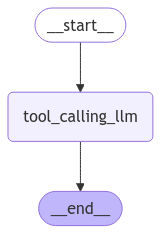

In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hXW7LG30HAqDzDNeAostliLq)
 Call ID: call_hXW7LG30HAqDzDNeAostliLq
  Args:
    a: 2
    b: 3
